# Práctica 3: Anemometría de Hilo Caliente (CTA/HWA) — Calibración y análisis

Este cuaderno explora automáticamente los datos en `files/p3` (carpeta del repositorio), procesa series E(t) de voltaje, agrega por condición de controlador (SD), calcula la curva de calibración usando la forma linealizada de la Ley de King $U^{1/n} = AE^2 + B$, y genera figuras y artefactos reproducibles.

Incluye: 
- Descubrimiento de datos (patrones: `files/p3/**`, soporta subcarpetas tipo `AO/AO_00-15`, etc.).
- Procesamiento por iteración: descarte de transientes, promedio E_iter, RMS opcional.
- Agregación por SD: E_SD, desviación estándar entre iteraciones, conteos.
- Velocidades de referencia U_ref(SD) via modelo lineal del túnel.
- Ajuste lineal de datos transformados (para obtener A, B, R²) y construcción de la curva final.
- Gráficas con guardado en PNG y SVG en `Practicas/P03_Hilo_Caliente/data/images`.
- Widgets interactivos para filtrar SD, ajustar n (2 o 3) y porcentajes de descarte.
- Exportación de tablas (CSV/Parquet) y resumen JSON; opción de actualizar `p3.md`.

Requisitos: numpy, pandas, matplotlib, seaborn, ipywidgets, scipy (opcional), tqdm. Si falta alguna dependencia, ejecuta la celda de instalación indicada.

In [1]:
# 1) Configuración del entorno y dependencias
import sys, os, re, json, math, logging, datetime as dt
from pathlib import Path
from typing import Iterable, Iterator, Tuple, Optional
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    import ipywidgets as widgets
except Exception:
    widgets = None
    print('ipywidgets no disponible. Puedes instalarlo y recargar el cuaderno.')
from importlib import reload
sns.set(context='notebook', style='whitegrid', palette='deep')
plt.rcParams['figure.dpi'] = 110
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')
logger = logging.getLogger('P03')

# Estructura relativa tipo P02: este notebook vive en Practicas/P03_Hilo_Caliente/notebooks
project_root = Path.cwd().parent  # .../Practicas/P03_Hilo_Caliente/
images_dir = project_root / 'data' / 'images'
data_dir = project_root / 'data'
def ensure_dir(p: Path):
    p.mkdir(parents=True, exist_ok=True)
ensure_dir(images_dir); ensure_dir(data_dir)
print('Si falta alguna dependencia, en una celda de Jupyter puedes ejecutar:')
print('%pip install numpy pandas matplotlib seaborn ipywidgets scipy tqdm')

Si falta alguna dependencia, en una celda de Jupyter puedes ejecutar:
%pip install numpy pandas matplotlib seaborn ipywidgets scipy tqdm


## Datos y utilidades

In [2]:
# 2) Utilidades para descubrir y leer datos en files/p3 (tolerantes a encabezados y nombres)
RE_SD_DIR = re.compile(r'(?:AO[_-]0*0?-?)(\\d+)$', re.IGNORECASE)  # p.ej., AO_00-15 -> 15
RE_SD_NUM = re.compile(r'(?:^|[^\\d])(1[5-9]|2[0-9]|3[0-5])([^\\d]|$)')  # 15..35 en texto

def find_repo_root_from_notebook() -> Path:
    # notebooks -> P03_Hilo_Caliente -> Practicas -> repo_root (3 niveles arriba)
    # Path.cwd() es .../Practicas/P03_Hilo_Caliente/notebooks
    repo_root = Path.cwd().parent.parent.parent
    if not (repo_root / '.git').exists() and not (repo_root / 'files').exists():
        logger.warning(f"La raíz del repo detectada ({repo_root}) podría no ser 'AERO-MESSURE'.")
    return repo_root

def find_p3_data_root() -> Path:
    repo_root = find_repo_root_from_notebook()
    # Aceptar 'files/p3' o 'files/P3' (la imagen muestra P3)
    data_root_p3_upper = repo_root / 'files' / 'P3'
    data_root_p3_lower = repo_root / 'files' / 'p3'
    
    if data_root_p3_upper.is_dir():
        return data_root_p3_upper
    if data_root_p3_lower.is_dir():
        return data_root_p3_lower
    
    raise FileNotFoundError(f"No se encontró el directorio de datos 'files/p3' o 'files/P3' en {repo_root}")

def parse_sd_from_path(p: Path) -> Optional[int]:
    # 1) Si el padre es AO_00-XX, tomar XX
    m = RE_SD_DIR.search(p.parent.name)
    if m:
        try:
            return int(m.group(1))
        except Exception:
            pass
    # 2) Buscar 15..35 embebido en nombre del archivo o directorios
    for part in [p.name, p.stem, p.parent.name]:
        m2 = RE_SD_NUM.search(part)
        if m2:
            try:
                return int(m2.group(1))
            except Exception:
                continue
    return None

def iter_hwa_files(p3_root: Path) -> Iterator[Tuple[int, Path]]:
    # Recorre recursivamente buscando .txt que contengan SD deducible
    for f in p3_root.rglob('*.txt'):
        sd = parse_sd_from_path(f)
        if sd is not None:
            yield sd, f

def read_voltage_series(filepath: Path) -> np.ndarray:
    # Intento 1: numpy.loadtxt directo
    try:
        arr = np.loadtxt(str(filepath), dtype=float)
        if arr.ndim == 0:
            arr = np.array([float(arr)])
        return np.ravel(arr).astype(float)
    except Exception:
        # Intento 2: Leer líneas, saltar encabezados no numéricos
        lines = []
        with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
            for line in f:
                try:
                    lines.append(float(line.strip()))
                except ValueError:
                    continue # Saltar encabezado o línea corrupta
        arr = np.array(lines, dtype=float)
        if arr.ndim == 0:
            arr = np.array([float(arr)])
        return np.ravel(arr).astype(float)


def trim_series(arr: np.ndarray, discard_head: float, discard_tail: float) -> np.ndarray:
    n = len(arr)
    if n == 0:
        return arr
    i0 = int(max(0, min(n, round(discard_head * n))))
    # Esta es la línea corregida
    i1 = int(max(i0, min(n, round(n * (1.0 - discard_tail)))))
    sub = arr[i0:i1]
    if sub.size == 0 and n > 0: # Si el descarte fue excesivo, devolver todo
        return arr
    return sub
def tunnel_velocity_from_sd(sd_percent: float, m: float, b: float) -> float:
    # U_ref [mm/s] = m * SD + b (coef. del túnel)
    return max(0.0, m * float(sd_percent) + b)

# Parámetros por defecto (pueden variarse con widgets)
SD_RANGE = list(range(15, 36))  # 15..35
N_KING_DEFAULT = 3.0  # n=3 (se puede alternar a 2)
COEF_M_SISTEMA = 7.6243
COEF_B_SISTEMA = -1.8926
DISCARD_HEAD = 0.10
DISCARD_TAIL = 0.10

In [3]:
# 3) Descubrimiento de archivos en files/p3
try:
    p3_root = find_p3_data_root()
    logger.info(f'Raíz P3: {p3_root}')
except FileNotFoundError as e:
    logger.error(str(e))
    raise
disc = []
for sd, f in iter_hwa_files(p3_root):
    disc.append({'file': str(f), 'SD': int(sd)})

DF_FILES = pd.DataFrame(disc).sort_values(['SD','file']).reset_index(drop=True)
display(DF_FILES.head())
logger.info(f'Archivos detectados: {len(DF_FILES)}')
missing = sorted(set(SD_RANGE) - set(DF_FILES['SD'].unique().tolist()))
if missing:
    logger.warning(f'SD esperados sin archivos: {missing}')

[INFO] Raíz P3: c:\Users\edgar\Documents\GitHub\Aero-Messure\files\P3


,file,SD
0,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15
1,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15
2,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15
3,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15
4,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15


[INFO] Archivos detectados: 134
[WARNING] SD esperados sin archivos: [19]


In [4]:
# 4) Procesamiento por iteración: E_mean y E_rms (porción útil)
def process_iteration_file(fpath: Path, discard_head=DISCARD_HEAD, discard_tail=DISCARD_TAIL) -> Tuple[float, float, int]:
    raw = read_voltage_series(fpath)
    sub = trim_series(raw, discard_head, discard_tail)
    if sub.size == 0:
        return float('nan'), float('nan'), 0
    return float(np.mean(sub)), float(np.std(sub, ddof=1) if sub.size>1 else 0.0), int(sub.size)

rows = []
# Usar tqdm si está disponible para mostrar barra de progreso
try:
    from tqdm.auto import tqdm
    iterator = tqdm(DF_FILES.iterrows(), total=len(DF_FILES), desc="Procesando archivos")
except ImportError:
    iterator = DF_FILES.iterrows()

for _, r in iterator:
    f = Path(r['file'])
    try:
        e_mean, e_rms, n_pts = process_iteration_file(f)
        rows.append({'file': str(f), 'SD': int(r['SD']), 'E_mean_V': e_mean, 'E_rms_V': e_rms, 'n_points': n_pts})
    except Exception as ex:
        logger.warning(f'Fallo procesando {f.name}: {ex}')

PER_ITER = pd.DataFrame(rows).sort_values(['SD','file']).reset_index(drop=True)
display(PER_ITER.head())
logger.info(f"Iteraciones válidas (con n_points > 0): { (PER_ITER['n_points'] > 0).sum() }")

Procesando archivos:   0%|          | 0/134 [00:00<?, ?it/s]

,file,SD,E_mean_V,E_rms_V,n_points
0,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15,-1.529637,1.434359,40000
1,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15,-1.533182,1.437136,40000
2,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15,-1.537036,1.435013,40000
3,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15,-1.535560,1.438668,40000
4,c:\Users\edgar\Documents\GitHub\Aero-Messure\f...,15,-1.537736,1.436170,40000


[INFO] Iteraciones válidas (con n_points > 0): 134


In [5]:
# 5) Agregación por SD (media de iteraciones y dispersión entre iteraciones)
def aggregate_by_sd(per_iter: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for sd, grp in per_iter.groupby('SD'):
        valid = grp[grp['n_points']>0]
        if valid.empty:
            continue
        e_means = valid['E_mean_V'].to_numpy()
        e_rms_iter = valid['E_rms_V'].to_numpy()
        e_sd_mean = float(np.mean(e_means))
        e_sd_std_between = float(np.std(e_means, ddof=1)) if e_means.size>1 else 0.0
        n_files = int(valid.shape[0])
        n_total_pts = int(valid['n_points'].sum())
        U_ref = tunnel_velocity_from_sd(sd, COEF_M_SISTEMA, COEF_B_SISTEMA)
        rows.append({
            'SD': int(sd),
            'E_SD_V': e_sd_mean,
            'E_SD_std_between_V': e_sd_std_between,
            'E_iter_rms_mean_V': float(np.mean(e_rms_iter)) if e_rms_iter.size>0 else 0.0,
            'U_ref_mm_s': float(U_ref),
            'n_files': n_files,
            'n_total_points': n_total_pts
        })
    return pd.DataFrame(rows).sort_values('SD').reset_index(drop=True)

PER_SD = aggregate_by_sd(PER_ITER)
display(PER_SD)
logger.info(f'Condiciones SD válidas: {len(PER_SD)}')

,SD,E_SD_V,E_SD_std_between_V,E_iter_rms_mean_V,U_ref_mm_s,n_files,n_total_points
0,15,-1.533365,0.004274,1.435167,112.4719,6,240000
1,16,-1.582204,0.025996,1.425063,120.0962,7,280000
2,17,-1.642150,0.009407,1.420394,127.7205,7,280000
3,18,-1.682378,0.060488,1.390662,135.3448,7,280000
4,20,-1.828437,0.025026,1.401290,150.5934,7,280000
5,21,-1.820016,0.042657,1.368042,158.2177,7,280000
6,22,-1.844705,0.121812,1.351977,165.8420,7,280000
7,23,-1.830296,0.049830,1.294179,173.4663,7,280000
8,24,-1.921012,0.039684,1.305111,181.0906,7,280000
9,25,-1.902236,0.062213,1.268092,188.7149,7,280000


[INFO] Condiciones SD válidas: 20


In [6]:
# 6) Transformación para ajuste King y guardado de tabla
def build_king_table(per_sd: pd.DataFrame, n_exp: float = N_KING_DEFAULT) -> pd.DataFrame:
    df = per_sd.copy()
    df['E_SD_sq_V2'] = df['E_SD_V']**2
    df['U_ref_pow_1_over_n'] = df['U_ref_mm_s'].clip(lower=1e-12)**(1.0/float(n_exp))
    return df

KING_DF = build_king_table(PER_SD, n_exp=N_KING_DEFAULT)
display(KING_DF)
# Guardado de calibración
calib_csv = data_dir / 'calibracion_p3.csv'
calib_parquet = data_dir / 'calibracion_p3.parquet'
KING_DF.to_csv(calib_csv, index=False)
try:
    KING_DF.to_parquet(calib_parquet, index=False)
except Exception as ex:
    logger.info(f'Parquet opcional no guardado: {ex}')
print('Tablas guardadas en:')
print(calib_csv)
print(calib_parquet) if calib_parquet.exists() else None

,SD,E_SD_V,E_SD_std_between_V,E_iter_rms_mean_V,U_ref_mm_s,n_files,n_total_points,E_SD_sq_V2,U_ref_pow_1_over_n
0,15,-1.533365,0.004274,1.435167,112.4719,6,240000,2.351208,4.827045
1,16,-1.582204,0.025996,1.425063,120.0962,7,280000,2.503368,4.933742
2,17,-1.642150,0.009407,1.420394,127.7205,7,280000,2.696656,5.036013
3,18,-1.682378,0.060488,1.390662,135.3448,7,280000,2.830397,5.134292
4,20,-1.828437,0.025026,1.401290,150.5934,7,280000,3.343180,5.320290
5,21,-1.820016,0.042657,1.368042,158.2177,7,280000,3.312457,5.408602
6,22,-1.844705,0.121812,1.351977,165.8420,7,280000,3.402937,5.494120
7,23,-1.830296,0.049830,1.294179,173.4663,7,280000,3.349983,5.577056
8,24,-1.921012,0.039684,1.305111,181.0906,7,280000,3.690287,5.657596
9,25,-1.902236,0.062213,1.268092,188.7149,7,280000,3.618503,5.735907


Tablas guardadas en:
c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P03_Hilo_Caliente\data\calibracion_p3.csv
c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P03_Hilo_Caliente\data\calibracion_p3.parquet


Ley de King (lin.): U^(1/n) = A*E^2 + B, n=3
A = 0.914101, B = 2.548633, R^2 = 0.872191
Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P03_Hilo_Caliente\data\images\p3_king_transform_fit.png
Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P03_Hilo_Caliente\data\images\p3_king_transform_fit.svg


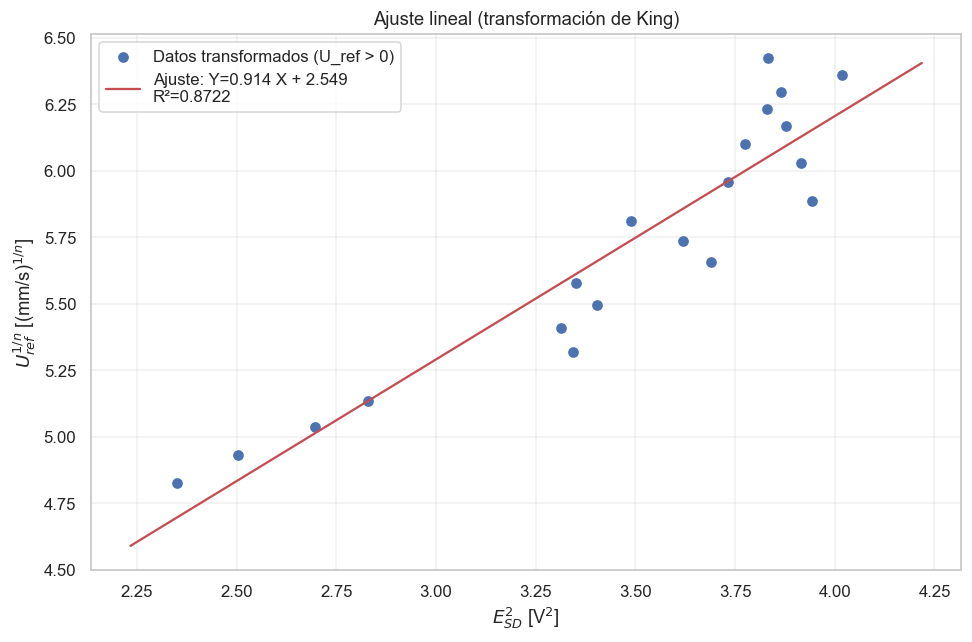

Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P03_Hilo_Caliente\data\images\p3_king_curve.png
Guardado: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P03_Hilo_Caliente\data\images\p3_king_curve.svg


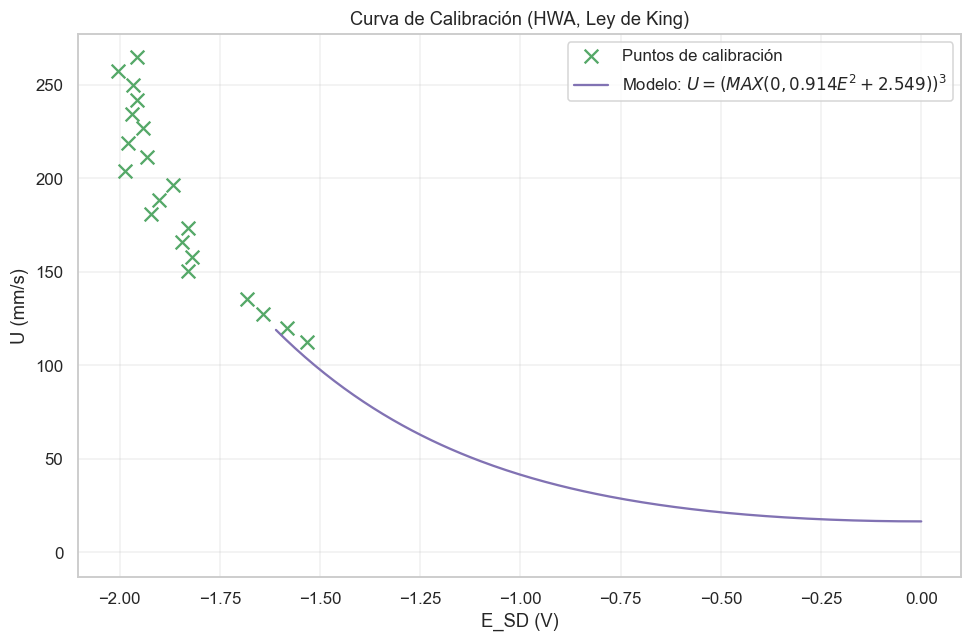

In [7]:
# 7) Ajuste lineal U^(1/n) = A*E^2 + B y figuras
def fit_king_linear(df: pd.DataFrame) -> Tuple[float, float, float]:
    X = df['E_SD_sq_V2'].to_numpy()
    Y = df['U_ref_pow_1_over_n'].to_numpy()
    if X.size < 2:
        return float('nan'), float('nan'), 0.0
    
    # y = a x + b (min cuadrados)
    # Ajuste de primer orden: A es pendiente, B es intercepto
    A, B = np.polyfit(X, Y, 1)
    
    # Calcular R^2
    Y_pred = A * X + B
    residuals = Y - Y_pred
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((Y - np.mean(Y))**2)
    
    if ss_tot < 1e-12: # Evitar división por cero si Y es constante
        R2 = 1.0 if ss_res < 1e-12 else 0.0
    else:
        R2 = 1.0 - (ss_res / ss_tot)
        
    return float(A), float(B), float(R2)

# Filtrar puntos donde U_ref es 0 (o casi 0) para evitar problemas en el ajuste
KING_DF_VALID = KING_DF[KING_DF['U_ref_mm_s'] > 1e-9].copy()
if len(KING_DF_VALID) < 2:
    logger.error("No hay suficientes puntos válidos (U_ref > 0) para el ajuste.")
    A, B, R2 = np.nan, np.nan, 0.0
else:
    A, B, R2 = fit_king_linear(KING_DF_VALID)

print(f'Ley de King (lin.): U^(1/n) = A*E^2 + B, n={N_KING_DEFAULT:.0f}')
print(f'A = {A:.6f}, B = {B:.6f}, R^2 = {R2:.6f}')

# Figura transformada
fig1, ax1 = plt.subplots(figsize=(9,6))
ax1.scatter(KING_DF_VALID['E_SD_sq_V2'], KING_DF_VALID['U_ref_pow_1_over_n'], c='C0', label='Datos transformados (U_ref > 0)')
if KING_DF['U_ref_mm_s'].min() <= 1e-9:
    ax1.scatter(KING_DF[KING_DF['U_ref_mm_s'] <= 1e-9]['E_SD_sq_V2'], KING_DF[KING_DF['U_ref_mm_s'] <= 1e-9]['U_ref_pow_1_over_n'], 
                c='gray', marker='s', label='Datos (U_ref = 0)', alpha=0.5)

if not math.isnan(A):
    # Usar rango de todos los datos para la línea
    x_min_all = KING_DF['E_SD_sq_V2'].min()
    x_max_all = KING_DF['E_SD_sq_V2'].max()
    xline = np.linspace(x_min_all * 0.95, x_max_all * 1.05, 200)
    yline = A * xline + B
    ax1.plot(xline, yline, 'r-', label=f'Ajuste: Y={A:.3f} X + {B:.3f}\nR²={R2:.4f}')
    
ax1.set_xlabel(r'$E_{SD}^2$ [V$^2$]')
ax1.set_ylabel(r'$U_{ref}^{1/n}$ [(mm/s)$^{1/n}$]')
ax1.set_title('Ajuste lineal (transformación de King)')
ax1.grid(True, alpha=0.3); ax1.legend(); fig1.tight_layout()
fig1_png = images_dir / 'p3_king_transform_fit.png'
fig1_svg = images_dir / 'p3_king_transform_fit.svg'
fig1.savefig(fig1_png); fig1.savefig(fig1_svg)
print('Guardado:', fig1_png)
print('Guardado:', fig1_svg)
plt.show()

# Figura final U vs E con curva King
fig2, ax2 = plt.subplots(figsize=(9,6))
ax2.scatter(KING_DF['E_SD_V'], KING_DF['U_ref_mm_s'], c='C2', marker='x', s=80, label='Puntos de calibración')
if not math.isnan(A):
    egrid = np.linspace(max(1e-9, float(KING_DF['E_SD_V'].min())*0.95), float(KING_DF['E_SD_V'].max())*1.05, 200)
    ucurve = np.maximum((A*(egrid**2) + B), 0.0)**N_KING_DEFAULT # Asegurar base >= 0
    ax2.plot(egrid, ucurve, 'm-', label=fr'Modelo: $U = (MAX(0, {A:.3f} E^2 + {B:.3f}))^{int(N_KING_DEFAULT)}$')
    
ax2.set_xlabel('E_SD (V)')
ax2.set_ylabel('U (mm/s)')
ax2.set_title('Curva de Calibración (HWA, Ley de King)')
ax2.grid(True, alpha=0.3); ax2.legend(); ax2.set_ylim(bottom=-max(KING_DF['U_ref_mm_s'].max()*0.05, 1.0)) # Margen inferior
fig2.tight_layout()
fig2_png = images_dir / 'p3_king_curve.png'
fig2_svg = images_dir / 'p3_king_curve.svg'
fig2.savefig(fig2_png); fig2.savefig(fig2_svg)
print('Guardado:', fig2_png)
print('Guardado:', fig2_svg)
plt.show()

In [8]:
# 8) Sensibilidad y propagación de incertidumbre (opcional)
def dU_dE(E: np.ndarray, A: float, B: float, n: float) -> np.ndarray:
    # U = (A E^2 + B)^n -> dU/dE = n*(A E^2 + B)^(n-1) * 2A E
    base = np.maximum(A*(E**2) + B, 0.0)
    return n * (np.maximum(base, 1e-12)**(n-1.0)) * (2.0*A*E)

def propagate_sigma_U(per_sd: pd.DataFrame, A: float, B: float, n: float) -> pd.DataFrame:
    df = per_sd.copy()
    E = df['E_SD_V'].to_numpy()
    sigma_E = np.maximum(df['E_SD_std_between_V'].to_numpy(), 1e-12)
    sens = dU_dE(E, A, B, n)
    df['U_calib_mm_s'] = np.maximum((A*(E**2) + B)**n, 0.0)
    df['U_sigma_mm_s'] = np.abs(sens) * sigma_E
    return df

UNC = propagate_sigma_U(PER_SD, A, B, N_KING_DEFAULT) if not math.isnan(A) else PER_SD.copy()
display(UNC.head())

,SD,E_SD_V,E_SD_std_between_V,E_iter_rms_mean_V,U_ref_mm_s,n_files,n_total_points,U_calib_mm_s,U_sigma_mm_s
0,15,-1.533365,0.004274,1.435167,112.4719,6,240000,103.682269,0.793349
1,16,-1.582204,0.025996,1.425063,120.0962,7,280000,113.166781,5.277829
2,17,-1.642150,0.009407,1.420394,127.7205,7,280000,126.026561,2.129777
3,18,-1.682378,0.060488,1.390662,135.3448,7,280000,135.472261,14.722183
4,20,-1.828437,0.025026,1.401290,150.5934,7,280000,176.052772,7.883250


In [9]:
# 9) Widgets interactivos para explorar n, descarte y SD
if widgets is None:
    print('Widgets no disponibles. Instala ipywidgets y recarga el notebook.')
else:
    sd_options = sorted(DF_FILES['SD'].unique().tolist())
    if not sd_options:
        print("No se encontraron SD en los archivos, los widgets no pueden iniciar.")
    else:
        sel_sds = widgets.SelectMultiple(options=sd_options, value=tuple(sd_options), description='SD', layout={'width': '200px'})
        n_choice = widgets.ToggleButtons(options=[2.0, 3.0], value=N_KING_DEFAULT, description='n (King)')
        head_slider = widgets.FloatSlider(value=DISCARD_HEAD, min=0.0, max=0.4, step=0.02, readout_format='.2f', description='Desc. inicio')
        tail_slider = widgets.FloatSlider(value=DISCARD_TAIL, min=0.0, max=0.4, step=0.02, readout_format='.2f', description='Desc. fin')
        out = widgets.Output()

        def recompute(*args):
            with out:
                out.clear_output(wait=True)
                # Filtrar archivos por SD
                df_files = DF_FILES[DF_FILES['SD'].isin(sel_sds.value)].copy()
                if df_files.empty:
                    print('No se seleccionó ningún SD.')
                    return
                
                rows = []
                for _, r in df_files.iterrows():
                    f = Path(r['file'])
                    e_mean, e_rms, n_pts = process_iteration_file(f, head_slider.value, tail_slider.value)
                    if n_pts > 0:
                        rows.append({'file': str(f), 'SD': int(r['SD']), 'E_mean_V': e_mean, 'E_rms_V': e_rms, 'n_points': n_pts})
                
                per_iter = pd.DataFrame(rows)
                if per_iter.empty:
                    print('Sin datos válidos con los filtros actuales.')
                    return
                
                per_sd = aggregate_by_sd(per_iter)
                kdf = build_king_table(per_sd, n_exp=float(n_choice.value))
                
                kdf_valid = kdf[kdf['U_ref_mm_s'] > 1e-9]
                if kdf_valid.shape[0] < 2:
                    print("No hay suficientes puntos válidos (U > 0) para el ajuste con esta configuración.")
                    return
                    
                A2, B2, R22 = fit_king_linear(kdf_valid)
                
                print(f"Resultados del ajuste interactivo (n={n_choice.value:.0f}):")
                print(f"A = {A2:.6f}, B = {B2:.6f}, R^2 = {R22:.6f}")
                display(per_sd)

                # Graficar transformada
                figi, axi = plt.subplots(figsize=(8,5))
                axi.scatter(kdf_valid['E_SD_sq_V2'], kdf_valid['U_ref_pow_1_over_n'], c='C0', label='Datos transf. (U>0)')
                if not math.isnan(A2):
                    x_min_all = kdf['E_SD_sq_V2'].min()
                    x_max_all = kdf['E_SD_sq_V2'].max()
                    xline = np.linspace(x_min_all * 0.95, x_max_all * 1.05, 200)
                    axi.plot(xline, A2*xline + B2, 'r-', label=f'Ajuste (R²={R22:.4f})')
                axi.set_xlabel(r'$E^2$ [V$^2$]'); axi.set_ylabel(r'$U^{1/n}$ [(mm/s)$^{1/n}$]')
                axi.grid(True, alpha=0.3); axi.legend(); figi.tight_layout()
                
                fig_name_trans = f'p3_interactive_transform_n{n_choice.value:.0f}_h{head_slider.value:.2f}_t{tail_slider.value:.2f}'
                figp = images_dir / f'{fig_name_trans}.png'
                figv = images_dir / f'{fig_name_trans}.svg'
                figi.savefig(figp); figi.savefig(figv)
                plt.show()

                # Curva final
                figk, axk = plt.subplots(figsize=(8,5))
                axk.scatter(kdf['E_SD_V'], kdf['U_ref_mm_s'], c='C2', marker='x', s=70, label='Calibración')
                if not math.isnan(A2):
                    egrid = np.linspace(max(1e-9, float(kdf['E_SD_V'].min())*0.95), float(kdf['E_SD_V'].max())*1.05, 200)
                    ucurve = np.maximum((A2*(egrid**2) + B2), 0.0)**float(n_choice.value)
                    axk.plot(egrid, ucurve, 'm-', label=f'King (n={n_choice.value:.0f})')
                axk.set_xlabel('E (V)'); axk.set_ylabel('U (mm/s)'); axk.grid(True, alpha=0.3); axk.legend(); figk.tight_layout()
                
                fig_name_curve = f'p3_interactive_curve_n{n_choice.value:.0f}_h{head_slider.value:.2f}_t{tail_slider.value:.2f}'
                figp2 = images_dir / f'{fig_name_curve}.png'
                figv2 = images_dir / f'{fig_name_curve}.svg'
                figk.savefig(figp2); figk.savefig(figv2)
                plt.show()

        for w in [sel_sds, n_choice, head_slider, tail_slider]:
            w.observe(recompute, names='value')
        
        display(widgets.VBox([widgets.HBox([sel_sds, widgets.VBox([n_choice, head_slider, tail_slider])]), out]))
        recompute()

In [10]:
# 10) Exportación de resumen JSON y (opcional) actualización de p3.md
summary = {
    'timestamp': dt.datetime.now().isoformat(),
    'N_KING_default': N_KING_DEFAULT,
    'model_king_linear': {'A': A, 'B': B, 'R2': R2},
    'SDs': PER_SD['SD'].tolist(),
    'images': {
        'transform_fit': str((images_dir/'p3_king_transform_fit.png').resolve()),
        'king_curve': str((images_dir/'p3_king_curve.png').resolve()),
    },
    'tables': {
        'calibracion_csv': str(calib_csv.resolve()),
        'calibracion_parquet': str(calib_parquet.resolve()) if calib_parquet.exists() else None,
    },
    'libs': {
        'numpy': np.__version__,
        'pandas': pd.__version__,
        'matplotlib': plt.matplotlib.__version__,
        'seaborn': sns.__version__,
    },
}
summary_path = data_dir / 'calibracion_p3_summary.json'
with open(summary_path, 'w', encoding='utf-8') as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)
print('Resumen guardado en:', summary_path)

# Opción de actualizar p3.md con resultados
# 'project_root' (P03_Hilo_Caliente) no es la raíz del repo (AERO-MESSURE)
# p3.md está en la raíz del repo (AERO-MESSURE), según la imagen
repo_root_path = find_repo_root_from_notebook()
p3_md_path = repo_root_path / 'p3.md'
backup_path = p3_md_path.with_suffix('.md.bak')

try:
    if p3_md_path.exists():
        # Leer contenido existente para no borrarlo
        original_content = p3_md_path.read_text(encoding='utf-8')
        # Crear backup
        backup_path.write_text(original_content, encoding='utf-8')
        logger.info(f'Respaldo creado: {backup_path.name}')
    else:
        original_content = f"# Práctica 3: Hilo Caliente (P03)\n\n"
        logger.info(f'Creando nuevo archivo: {p3_md_path.name}')

    # Definir el marcador para reemplazar
    marker_start = ""
    marker_end = ""
    
    sec = []
    sec.append(marker_start + "\n")
    sec.append("## Resultados Automáticos (Generados por Notebook)\n")
    sec.append(f"*(Actualizado: {dt.datetime.now().isoformat()})*\n\n")
    sec.append(f"Ajuste Ley de King con $n={N_KING_DEFAULT:.0f}$:\n")
    sec.append(f"- **$A$**: `{A:.7g}`\n")
    sec.append(f"- **$B$**: `{B:.7g}`\n")
    sec.append(f"- **$R^2$**: `{R2:.7f}`\n\n")
    
    # Usar rutas relativas desde p3.md (en raíz) a las imágenes (en Practicas/P03_.../data/images)
    try:
        # Calcular ruta relativa desde la ubicación del MD a la carpeta de imágenes
        md_parent_dir = p3_md_path.parent
        img_rel_path = os.path.relpath(images_dir.resolve(), md_parent_dir.resolve())
        # Reemplazar separadores de Windows por / para markdown
        img_rel_path = img_rel_path.replace(os.path.sep, '/')
    except Exception:
        # Fallback si falla el cálculo de ruta relativa
        img_rel_path = f"Practicas/P03_Hilo_Caliente/data/images"

    sec.append(f"### Curva de Calibración $U(E)$ \n")
    sec.append(f"![Curva de King]({img_rel_path}/p3_king_curve.png)\n\n")
    sec.append(f"### Ajuste Lineal $U^{{1/n}}(E^2)$ \n")
    sec.append(f"![Ajuste lineal]({img_rel_path}/p3_king_transform_fit.png)\n\n")
    sec.append(marker_end + "\n")
    
    new_results = "".join(sec)
    
    # Reemplazar la sección de resultados si existe, o añadirla al final
    re_marker = re.compile(f"{re.escape(marker_start)}.*{re.escape(marker_end)}", re.DOTALL)
    
    if re_marker.search(original_content):
        final_content = re_marker.sub(new_results, original_content)
    else:
        final_content = original_content + "\n" + new_results

    with open(p3_md_path, 'w', encoding='utf-8') as f:
        f.write(final_content)
    logger.info(f'Resultados actualizados en: {p3_md_path.name}')

except Exception as e_md:
    logger.error(f'No se pudo actualizar {p3_md_path.name}: {e_md}')
    # Restaurar backup si falló
    if backup_path.exists():
        backup_path.replace(p3_md_path)
        logger.warning(f'Fallo al escribir MD, backup restaurado.')

[INFO] Creando nuevo archivo: p3.md
[INFO] Resultados actualizados en: p3.md


Resumen guardado en: c:\Users\edgar\Documents\GitHub\Aero-Messure\Practicas\P03_Hilo_Caliente\data\calibracion_p3_summary.json


In [11]:
# 11) Comprobaciones básicas
assert not DF_FILES.empty, 'No se encontraron archivos en files/p3'
assert (PER_ITER['n_points']>0).any(), 'Ningún archivo produjo muestras válidas'
assert PER_SD.shape[0] >= 2, 'Se requieren >=2 SD para regresión'
assert 0.0 <= R2 <= 1.0, 'R^2 fuera de [0,1]'
print('Checks básicos: OK')

Checks básicos: OK


## Conceptos clave: CTA/HWA, Ley de King y consideraciones prácticas

- En modo CTA (temperatura constante), el anemómetro ajusta la corriente al hilo para mantener su temperatura; lo que se mide directamente es un voltaje/corriente proporcional al calor evacuado por convección.
- La Ley de King relaciona el flujo de calor con la velocidad. En práctica se usa la forma empírica: $U^{1/n} = AE^2 + B$, con $n$ típico entre 2 y 3.
- La calibración es imprescindible: A, B (y n) dependen del montaje, temperatura del fluido, hilo y electrónica.
- Sensibilidad: $\frac{dU}{dE} = n (A E^2 + B)^{n-1} 2 A E$. Útil para propagar incertidumbre de voltaje a velocidad.
- Cuidar descartar transitorios iniciales/finales y mantener temperatura del fluido estable. Limpieza del hilo y estabilidad del CTA son críticas.
- Para caracterizar turbulencia, se requeriría convertir fluctuaciones de $E'(t)$ a $u'(t)$ mediante la derivada local de la curva $U(E)$ o un modelo lineal local; este cuaderno reporta RMS de voltaje por iteración a modo indicativo.